In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
train_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train'
test_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test'
validate_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid'

normal_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train/normal'
adenocarcinoma_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

normal_folder_test = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test/normal'
adenocarcinoma_folder_test = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder_test = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder_test = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

normal_folder_validate = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid/normal'
adenocarcinoma_folder_validate = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder_validate = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder_validate = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Define your folder paths
train_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train'
test_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/test'
validate_folder = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid'

# Define the image size
IMAGE_SIZE = (350, 350)

print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

# Set up data augmentation for training and test data
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8

# Create the train generator for loading images
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

# Create the validation generator for loading images
validation_generator = test_datagen.flow_from_directory(
    validate_folder,  # Use validate_folder here for validation data
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/train
Reading validation images from: /content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Reduce learning rate when the loss stops improving
learning_rate_reduction = ReduceLROnPlateau(
    monitor='loss',       # Monitors the loss
    patience=5,           # Waits for 5 epochs with no improvement
    verbose=2,            # Prints a message when the learning rate is reduced
    factor=0.5,           # Reduces the learning rate by a factor of 0.5
    min_lr=0.000001       # Sets a lower bound for the learning rate
)

# Stop training if the loss does not improve
early_stops = EarlyStopping(
    monitor='loss',       # Monitors the loss
    min_delta=0,          # Minimum change to qualify as an improvement
    patience=6,           # Stops after 6 epochs with no improvement
    verbose=2,            # Prints a message when stopping
    mode='auto'           # Automatically decides whether to minimize or maximize the loss
)

# Save the model (architecture + weights) when the model achieves the best performance
checkpointer = ModelCheckpoint(filepath='/content/best_model.keras', verbose=2, save_best_only=True, save_weights_only=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import Xception

# Set image size
IMAGE_SIZE = (350, 350)

# Pretrained model (Xception) without the top layer
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

# Freeze the pretrained layers
pretrained_model.trainable = False

# Create the final model
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())  # Add GlobalAveragePooling
model.add(Dense(4, activation='softmax'))  # Output layer with 4 classes

# Build the model to define the input shape
model.build(input_shape=(None, 350, 350, 3))

# Show the summary of the pretrained model
print("Pretrained model used:")
pretrained_model.summary()

# Show the summary of the final model
print("Final model created:")
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 350, 350, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 11, 11, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 1:24 17s/step - accuracy: 0.4285 - loss: 1.2740
Epoch 1: val_loss improved from inf to 1.09003, saving model to /content/best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 391s 15s/step - accuracy: 0.4404 - loss: 1.2564 - val_accuracy: 0.4861 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 2/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 1:24 17s/step - accuracy: 0.6088 - loss: 0.9691
Epoch 2: val_loss improved from 1.09003 to 0.98938, saving model to /content/best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 436s 15s/step - accuracy: 0.6097 - loss: 0.9642 - val_accuracy: 0.5000 - val_loss: 0.9894 - learning_rate: 0.0010
Epoch 3/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 1:24 17s/step - accuracy: 0.6669 - loss: 0.8429
Epoch 3: val_loss improved from 0.98938 to 0.87643, saving model to /content/best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 381s 15s/step - accuracy: 0.6692 - loss: 0.8416 - val_accuracy: 0.5972 - val_loss: 0.8764 - learning_rate: 0.0010
Epoch 4/50
20/25 ━━━━━━━━━━━━━━━━━━━━ 1:2

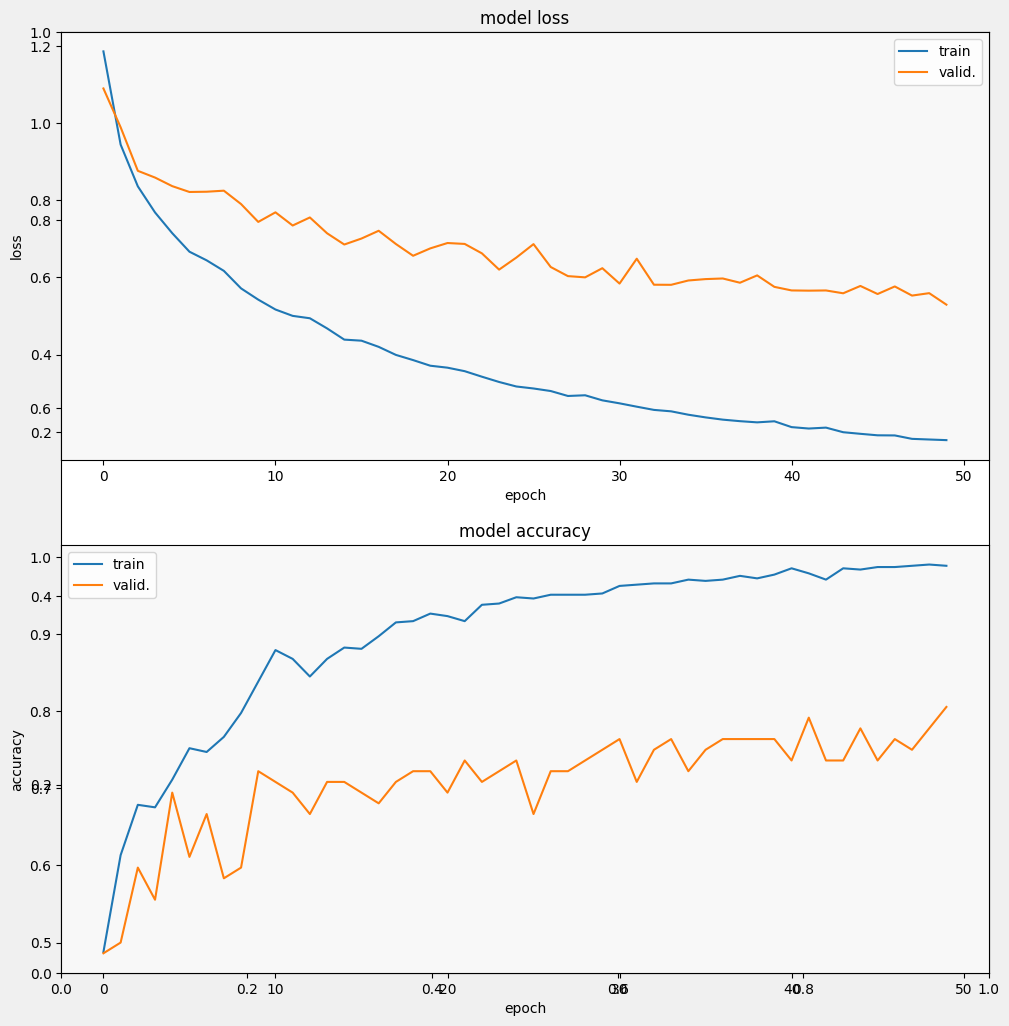

In [20]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [21]:
model.save('/content/drive/MyDrive/dataset/trained_lung_cancer_model.hdf5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


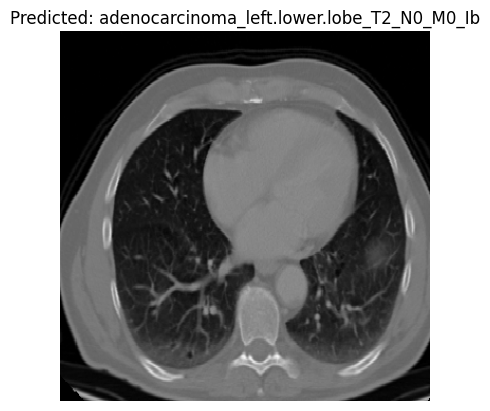

In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Lung-Cancer-Prediction-using-CNN-and-Transfer-Learning/dataset/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000112 (9).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
The image belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa


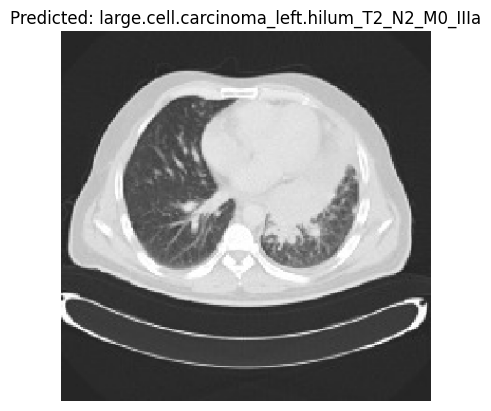

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/thumb.jpg'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/l3.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/n8.jpg'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
